In [48]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

# LSTM Implementation from Scratch

This notebook implements a Long Short-Term Memory (LSTM) network from scratch using only NumPy.

## LSTM Architecture

An LSTM cell has:
- **Forget Gate**: Decides what information to discard from cell state
- **Input Gate**: Decides what new information to store
- **Output Gate**: Decides what to output based on cell state

The equations are:
- $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$ (Forget gate)
- $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$ (Input gate)
- $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$ (Candidate cell state)
- $C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$ (Cell state)
- $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$ (Output gate)
- $h_t = o_t \odot \tanh(C_t)$ (Hidden state)

## Helper Functions

In [49]:
def sigmoid(x):
    """Sigmoid activation function with numerical stability."""
    return np.where(
        x >= 0, 
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    """Derivative of sigmoid function."""
    s = sigmoid(x)
    return s * (1 - s)

def tanh_derivative(x):
    """Derivative of tanh function."""
    return 1 - np.tanh(x) ** 2

In [50]:
np.random.randn(32, 40)

array([[-0.95209721, -0.74544106,  1.73837013, ...,  0.03499308,
        -0.34464169, -0.72503229],
       [ 1.03960617, -0.24172804, -0.11290536, ...,  1.84436521,
         0.69556401, -0.1816892 ],
       [-0.42226065,  1.01172044, -0.06675741, ...,  0.28026028,
         1.49663046, -0.68415163],
       ...,
       [ 1.89438752, -1.07073912,  1.56225116, ...,  1.46374233,
         0.71877389, -0.55808162],
       [-0.41143003,  0.7266316 ,  1.16866856, ...,  0.36996318,
        -0.61715586,  1.78714941],
       [ 0.78590931,  1.4386236 , -0.37318587, ..., -2.01836273,
        -0.46105028,  0.60764267]], shape=(32, 40))

## LSTM Cell Implementation

In [51]:
class LSTMCell:
    """Single LSTM cell implementation."""
    
    def __init__(self, input_size: int, hidden_size: int, seed: Optional[int] = None):
        """
        Initialize LSTM cell parameters.
        
        Args:
            input_size: Dimension of input features
            hidden_size: Dimension of hidden state
            seed: Random seed for reproducibility
        """
        if seed is not None:
            np.random.seed(seed)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Xavier initialization
        scale = np.sqrt(2.0 / (input_size + hidden_size))
        
        # Forget gate parameters; the weight matrix dimensions are (hidden_size, input_size + hidden_size)
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bf = np.zeros((hidden_size, 1))
        
        # Input gate parameters
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bi = np.zeros((hidden_size, 1))
        
        # Candidate cell state parameters
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bc = np.zeros((hidden_size, 1))
        
        # Output gate parameters
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bo = np.zeros((hidden_size, 1))
        
        # Gradients (initialized during backprop)
        self.dWf = np.zeros_like(self.Wf)
        self.dbf = np.zeros_like(self.bf)
        self.dWi = np.zeros_like(self.Wi)
        self.dbi = np.zeros_like(self.bi)
        self.dWc = np.zeros_like(self.Wc)
        self.dbc = np.zeros_like(self.bc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbo = np.zeros_like(self.bo)
    
    def forward(self, x: np.ndarray, h_prev: np.ndarray, c_prev: np.ndarray) -> Tuple[np.ndarray, np.ndarray, dict]:
        """
        Forward pass through LSTM cell.
        
        Args:
            x: Input at current timestep (input_size, 1)
            h_prev: Previous hidden state (hidden_size, 1)
            c_prev: Previous cell state (hidden_size, 1)
            
        Returns:
            h_next: Next hidden state
            c_next: Next cell state
            cache: Dictionary of intermediate values for backprop
        """
        # Concatenate previous hidden state and input
        concat = np.vstack((h_prev, x))
        
        # Forget gate; @ is operator for matrix multiplication; dimension: h*(h+x) @ (h+x)*1
        # f_gate is of shape (hidden_size, 1)
        f_gate = sigmoid(self.Wf @ concat + self.bf)
        
        # Input gate
        i_gate = sigmoid(self.Wi @ concat + self.bi)
        
        # Candidate cell state
        c_tilde = np.tanh(self.Wc @ concat + self.bc)
        
        # New cell state
        c_next = f_gate * c_prev + i_gate * c_tilde
        
        # Output gate
        o_gate = sigmoid(np.dot(self.Wo, concat) + self.bo)
        
        # New hidden state
        h_next = o_gate * np.tanh(c_next)
        
        # Cache for backpropagation
        cache = {
            'x': x, 'h_prev': h_prev, 'c_prev': c_prev,
            'concat': concat, 'f_gate': f_gate, 'i_gate': i_gate,
            'c_tilde': c_tilde, 'c_next': c_next, 'o_gate': o_gate,
            'h_next': h_next
        }
        
        return h_next, c_next, cache

## LSTM Network with Backpropagation Through Time (BPTT)

In [52]:
class LSTM:
    """LSTM network that processes sequences."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int, seed: Optional[int] = None):
        """
        Initialize LSTM network.
        
        Args:
            input_size: Dimension of input features
            hidden_size: Dimension of hidden state
            output_size: Dimension of output
            seed: Random seed for reproducibility
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # LSTM cell
        self.cell = LSTMCell(input_size, hidden_size, seed)
        
        # Output layer
        if seed is not None:
            np.random.seed(seed + 1)
        scale = np.sqrt(2.0 / hidden_size)
        self.Wy = np.random.randn(output_size, hidden_size) * scale
        self.by = np.zeros((output_size, 1))
        
        # Gradients for output layer
        self.dWy = np.zeros_like(self.Wy)
        self.dby = np.zeros_like(self.by)
    
    def forward(self, inputs: np.ndarray) -> Tuple[List[np.ndarray], List[dict]]:
        """
        Forward pass through entire sequence. This is a Many-to-Many LSTM.
        
        Args:
            inputs: Sequence of inputs, shape (seq_length, input_size, 1)
            
        Returns:
            outputs: List of outputs at each timestep
            caches: List of cache dictionaries for backprop
        """
        seq_length = len(inputs)
        # initialize hidden and cell states with zeros
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        
        outputs = []
        caches = []
        
        for t in range(seq_length):
            h, c, cache = self.cell.forward(inputs[t], h, c)
            
            # Compute output FOR EVERY TIMESTEP
            y = self.Wy @ h + self.by
            
            cache['y'] = y
            caches.append(cache)
            outputs.append(y)
        
        return outputs, caches
    
    def backward(self, dy_list: List[np.ndarray], caches: List[dict]) -> None:
        """
        Backward pass through time (BPTT).
        
        Args:
            dy_list: List of gradients of loss w.r.t. outputs
            caches: List of cached values from forward pass
        """
        seq_length = len(caches)
        
        # Reset gradients
        self.cell.dWf.fill(0)
        self.cell.dbf.fill(0)
        self.cell.dWi.fill(0)
        self.cell.dbi.fill(0)
        self.cell.dWc.fill(0)
        self.cell.dbc.fill(0)
        self.cell.dWo.fill(0)
        self.cell.dbo.fill(0)
        self.dWy.fill(0)
        self.dby.fill(0)
        
        # Initialize gradients flowing back through time
        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros((self.hidden_size, 1))
        
        # Backward pass through time (BPTT)
        for t in reversed(range(seq_length)):
            cache = caches[t]
            dy = dy_list[t]
            
            # Gradient of output layer
            self.dWy += dy @ cache['h_next'].T
            self.dby += dy
            
            # Gradient flowing to hidden state
            dh = self.Wy.T @ dy + dh_next
            
            # Backprop through LSTM cell
            dh_next, dc_next = self._backward_cell(dh, dc_next, cache)
    
    def _backward_cell(self, dh: np.ndarray, dc_next: np.ndarray, cache: dict) -> Tuple[np.ndarray, np.ndarray]:
        """
        Backward pass through a single LSTM cell.
        
        Args:
            dh: Gradient of loss w.r.t. hidden state
            dc_next: Gradient of loss w.r.t. cell state from next timestep
            cache: Cached values from forward pass
            
        Returns:
            dh_prev: Gradient w.r.t. previous hidden state
            dc_prev: Gradient w.r.t. previous cell state
        """
        # Extract cached values
        x = cache['x']
        h_prev = cache['h_prev']
        c_prev = cache['c_prev']
        concat = cache['concat']
        f_gate = cache['f_gate']
        i_gate = cache['i_gate']
        c_tilde = cache['c_tilde']
        c_next = cache['c_next']
        o_gate = cache['o_gate']
        
        # Gradient of output gate
        do = dh * np.tanh(c_next)
        do_input = do * o_gate * (1 - o_gate)
        
        # Gradient of cell state
        dc = dh * o_gate * (1 - np.tanh(c_next) ** 2) + dc_next
        
        # Gradient of candidate cell state
        dc_tilde = dc * i_gate
        dc_tilde_input = dc_tilde * (1 - c_tilde ** 2)
        
        # Gradient of input gate
        di = dc * c_tilde
        di_input = di * i_gate * (1 - i_gate)
        
        # Gradient of forget gate
        df = dc * c_prev
        df_input = df * f_gate * (1 - f_gate)
        
        # Accumulate parameter gradients
        self.cell.dWf += df_input @ concat.T
        self.cell.dbf += df_input
        
        self.cell.dWi += di_input @ concat.T
        self.cell.dbi += di_input
        
        self.cell.dWc += dc_tilde_input @ concat.T
        self.cell.dbc += dc_tilde_input
        
        self.cell.dWo += do_input @ concat.T
        self.cell.dbo += do_input
        
        # Gradient of concatenated input
        dconcat = (self.cell.Wf.T @ df_input + 
                   self.cell.Wi.T @ di_input + 
                   self.cell.Wc.T @ dc_tilde_input + 
                   self.cell.Wo.T @ do_input)
        
        # Split gradient
        dh_prev = dconcat[:self.hidden_size, :]
        dc_prev = dc * f_gate
        
        return dh_prev, dc_prev
    
    def update_parameters(self, learning_rate: float, clip_value: float = 5.0) -> None:
        """
        Update parameters using gradient descent with gradient clipping.
        
        Args:
            learning_rate: Learning rate for gradient descent
            clip_value: Maximum gradient magnitude for clipping
        """
        # Clip gradients to prevent exploding gradients
        for dparam in [self.cell.dWf, self.cell.dbf, self.cell.dWi, self.cell.dbi,
                       self.cell.dWc, self.cell.dbc, self.cell.dWo, self.cell.dbo,
                       self.dWy, self.dby]:
            np.clip(dparam, -clip_value, clip_value, out=dparam)
        
        # Update LSTM cell parameters
        self.cell.Wf -= learning_rate * self.cell.dWf
        self.cell.bf -= learning_rate * self.cell.dbf
        self.cell.Wi -= learning_rate * self.cell.dWi
        self.cell.bi -= learning_rate * self.cell.dbi
        self.cell.Wc -= learning_rate * self.cell.dWc
        self.cell.bc -= learning_rate * self.cell.dbc
        self.cell.Wo -= learning_rate * self.cell.dWo
        self.cell.bo -= learning_rate * self.cell.dbo
        
        # Update output layer parameters
        self.Wy -= learning_rate * self.dWy
        self.by -= learning_rate * self.dby

## Training Utilities

In [53]:
def mse_loss(predictions: List[np.ndarray], targets: List[np.ndarray]) -> Tuple[float, List[np.ndarray]]:
    """
    Compute Mean Squared Error loss and gradients.
    
    Args:
        predictions: List of predicted values
        targets: List of target values
        
    Returns:
        loss: Average MSE loss
        gradients: List of gradients w.r.t. predictions
    """
    loss = 0
    gradients = []
    
    for pred, target in zip(predictions, targets):
        diff = pred - target
        loss += np.sum(diff ** 2)
        gradients.append(2 * diff)
    
    loss /= len(predictions)
    return loss, gradients

def train_lstm(model: LSTM, X_train: List[np.ndarray], y_train: List[np.ndarray], 
               epochs: int, learning_rate: float, verbose: bool = True) -> List[float]:
    """
    Train LSTM model.
    
    Args:
        model: LSTM model instance
        X_train: List of training sequences
        y_train: List of target sequences
        epochs: Number of training epochs
        learning_rate: Learning rate for optimization
        verbose: Whether to print progress
        
    Returns:
        losses: List of losses per epoch
    """
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for X_seq, y_seq in zip(X_train, y_train):
            # Forward pass
            outputs, caches = model.forward(X_seq)
            
            # Compute loss
            loss, gradients = mse_loss(outputs, y_seq)
            epoch_loss += loss
            
            # Backward pass
            model.backward(gradients, caches)
            
            # Update parameters
            model.update_parameters(learning_rate)
        
        epoch_loss /= len(X_train)
        losses.append(epoch_loss)
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")
    
    return losses

## Example: Learning a Sine Wave

Let's test our LSTM implementation by training it to predict future values of a sine wave.

In [54]:
# Generate synthetic sine wave data
def generate_sine_data(n_samples: int = 100, seq_length: int = 20, n_sequences: int = 50):
    """Generate sine wave sequences for training."""
    X_data = []
    y_data = []
    
    for _ in range(n_sequences):
        # Generate sine wave
        t = np.linspace(0, 4 * np.pi, n_samples)
        data = np.sin(t)
        
        # Create sequences
        for i in range(n_samples - seq_length - 1):
            X_seq = data[i:i + seq_length]
            y_seq = data[i + 1:i + seq_length + 1]
            
            # Reshape for LSTM (seq_length, input_size, 1)
            X_seq = X_seq.reshape(-1, 1, 1)
            y_seq = y_seq.reshape(-1, 1, 1)
            
            X_data.append(X_seq)
            y_data.append(y_seq)
    
    return X_data, y_data

# Generate data
np.random.seed(42)
X_train, y_train = generate_sine_data(n_samples=100, seq_length=50, n_sequences=20)

print(f"Generated {len(X_train)} training sequences")
print(f"Each sequence has shape: {X_train[0].shape}")

Generated 980 training sequences
Each sequence has shape: (50, 1, 1)


In [55]:
values = X_train[0].tolist()
# get rid of extra list layer
values = [v[0] for v in values]
values = [v[0] for v in values]

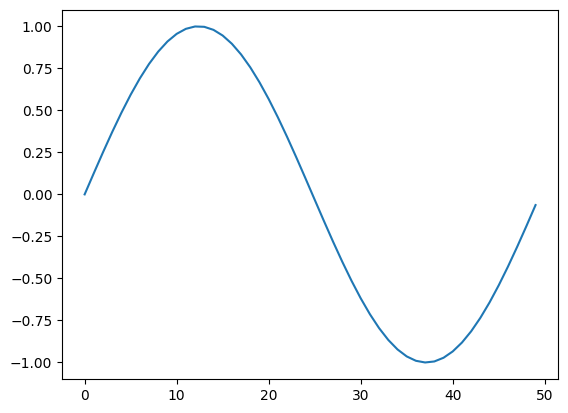

In [56]:
import matplotlib.pyplot as plt
plt.plot(values)

In [57]:
# Initialize LSTM model
input_size = 1
hidden_size = 16
output_size = 1

lstm = LSTM(input_size, hidden_size, output_size, seed=42)
print(f"LSTM initialized with {hidden_size} hidden units")

LSTM initialized with 16 hidden units


In [58]:
# Train the model
losses = train_lstm(
    model=lstm,
    X_train=X_train,
    y_train=y_train,
    epochs=50,
    learning_rate=0.01,
    verbose=True
)

Epoch 10/50, Loss: 0.000625
Epoch 20/50, Loss: 0.000508
Epoch 20/50, Loss: 0.000508
Epoch 30/50, Loss: 0.000417
Epoch 30/50, Loss: 0.000417
Epoch 40/50, Loss: 0.000363
Epoch 40/50, Loss: 0.000363
Epoch 50/50, Loss: 0.000323
Epoch 50/50, Loss: 0.000323


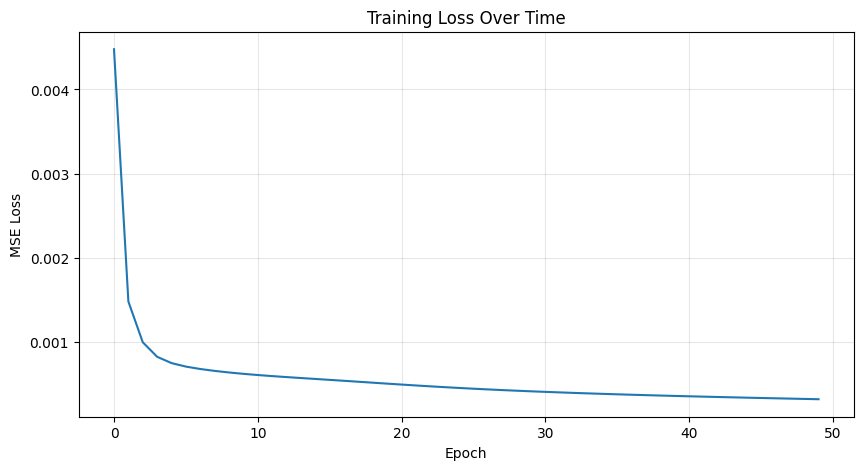

In [59]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.show()

## Test the Model: Predict Future Values

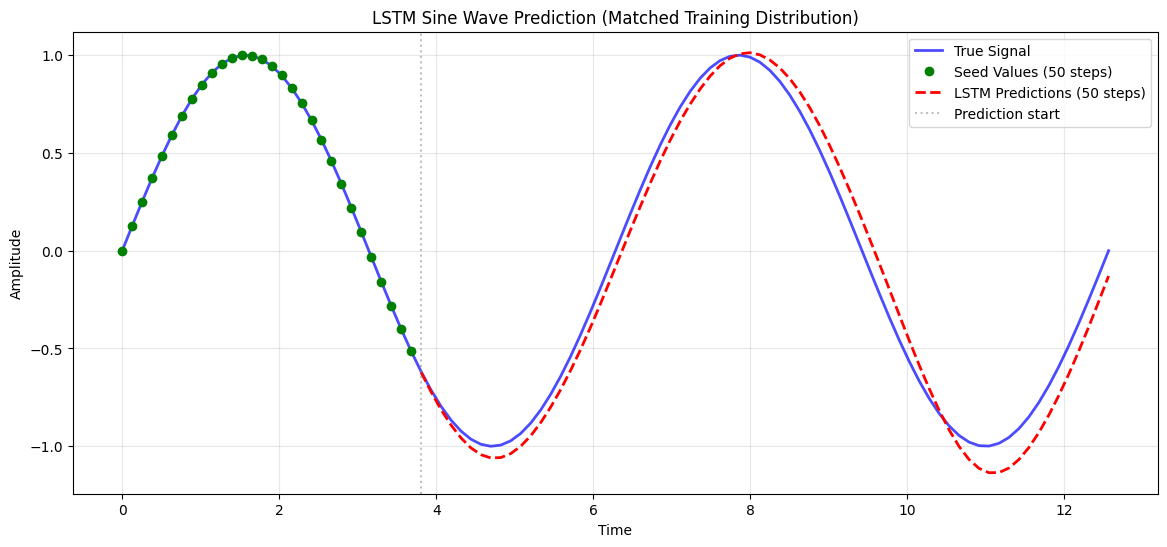


Prediction MSE: 0.009747
Test sequence: 100 points over 12.57 radians
Seed length: 30 points
Predicted: 70 points


In [62]:
# Generate test sequence with SAME characteristics as training
# Training used: 100 samples over 4*pi
np.random.seed(123)  # Different seed for test
t_test = np.linspace(0, 4 * np.pi, 100)
true_signal = np.sin(t_test)

# Use first 50 points as seed (same as training seq_length), predict next 50
seed_length = 30
seed_sequence = true_signal[:seed_length].reshape(-1, 1, 1)

# Predict future values (only 50 steps, matching training)
predictions = []
current_seq = list(seed_sequence)

for _ in range(len(true_signal) - seed_length):
    # Predict next value
    outputs, _ = lstm.forward(current_seq)
    next_val = outputs[-1]
    predictions.append(next_val[0, 0])
    
    # Update sequence (sliding window)
    current_seq = current_seq[1:] + [next_val]

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(t_test, true_signal, 'b-', label='True Signal', linewidth=2, alpha=0.7)
plt.plot(t_test[:seed_length], true_signal[:seed_length], 'go', label='Seed Values (50 steps)', markersize=6)
plt.plot(t_test[seed_length:], predictions, 'r--', label='LSTM Predictions (50 steps)', linewidth=2)
plt.axvline(x=t_test[seed_length], color='gray', linestyle=':', alpha=0.5, label='Prediction start')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('LSTM Sine Wave Prediction (Matched Training Distribution)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate prediction error
prediction_error = np.mean((true_signal[seed_length:] - np.array(predictions)) ** 2)
print(f"\nPrediction MSE: {prediction_error:.6f}")
print(f"Test sequence: {len(true_signal)} points over {4*np.pi:.2f} radians")
print(f"Seed length: {seed_length} points")
print(f"Predicted: {len(predictions)} points")